In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

# using Plots
using CairoMakie
using Random
using Printf
using DataFrames
using JLD
using StatsPlots
using LinearAlgebra
using NearestNeighbors
using DataInterpolations
using Clustering
using GraphMakie
using Graphs
using ClusterValidityIndices
using MultivariateStats
using KernelDensity
using NetworkLayout
using TravelingSalesmanExact, GLPK

┌ Warning: Error requiring `UnicodePlots` from `Plots`
│   exception = (LoadError("/Users/boothh/.julia/packages/Plots/qgrW8/src/backends/unicodeplots.jl", 277, LoadError("/Users/boothh/.julia/packages/Plots/qgrW8/src/backends/unicodeplots.jl", 315, UndefVarError(:FileIO))), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000104f05d1f, Ptr{Nothing} @0x0000000104f342d3, Ptr{Nothing} @0x0000000104f503a3, Ptr{Nothing} @0x0000000104f4f283, Ptr{Nothing} @0x0000000104f261db, Ptr{Nothing} @0x0000000104f23777, Ptr{Nothing} @0x0000000104f236df, Ptr{Nothing} @0x0000000104f236df, Ptr{Nothing} @0x0000000104f236df, Ptr{Nothing} @0x0000000104f236df, Ptr{Nothing} @0x0000000104f236df, Ptr{Nothing} @0x0000000104f236df, Ptr{Nothing} @0x0000000104f236df, Ptr{Nothing} @0x0000000104f23feb, Ptr{Nothing} @0x0000000104f4f7d7, Ptr{Nothing} @0x0000000104f5034b, Ptr{Nothing} @0x0000000104f510ef, Ptr{Nothing} @0x000000011cd109c3, Ptr{Nothing} @0x0000000104f1be63, Ptr{Nothing} @0x00000002e6a44377, Ptr{

In [258]:
# run_data = load(datadir("sims/repeated_evolution_different_topologies/a3.jld2"))["raw_data"]; #a3 2500, one mutation
# run_data = load(datadir("sims/repeated_evolution_different_topologies/more_than_one_mut.jld2"))["raw_data"]; #a3 2500, more than one mutation (binomial, 0.2)

run_data = load(datadir("sims/repeated_evolution_different_topologies/bta_not_inf_single_mut.jld2"))["raw_data"]; #a3 2500, more than one mutation (binomial, 0.2)

In [259]:
function refresh_type(v)
    [i for i in v]
end

mutable struct GenoTrajectories

    fitness_traj :: Vector{Vector{Float64}}
    traj :: Vector{Vector{Matrix{Float64}}}

    geno_traj :: Vector{Matrix{Float64}}

    initial_fitness :: Float64
    initial_genotype :: Vector{Float64}

    full_geno_traj :: Union{Vector{Matrix{Float64}}, Nothing}
    cluster_assignments :: Union{Vector{Int64}, Nothing}
    fgt_data :: Union{Matrix{Float64},Nothing}
    distance_mat ::  Union{Matrix{Float64},Nothing}

    max_clusters :: Union{Int64, Nothing}
    optimal_n_cluster :: Union{Int64, Nothing}
    criterion_values :: Union{Vector{Float64},Nothing}

    debug ::Any
end

function GenoTrajectories(evo_traces::Vector{EvoTrace})

    fitness_traj = map(et->refresh_type(map(x->x[1],et.fitness_trajectory)),evo_traces)
    geno_traj = map(et->reduce(hcat,map(x->vec(x),et.traversed_topologies)),evo_traces);

    traj = map(et->unique(et.traversed_topologies),evo_traces);

    initial_fitness = fitness_traj[1][1]
    initial_genotype = vec(evo_traces[1].traversed_topologies[1])

    GenoTrajectories(fitness_traj,traj,geno_traj,initial_fitness, initial_genotype,nothing,nothing,nothing,nothing,nothing,nothing,nothing,nothing)

end

function select_marker(edge_value)
    edge_value > 0 ? :ltriangle : :vline
end

function draw_grn(network,color_scheme)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.02, 0.0],
                [-0.03, -0.05],
                [0.01, -0.05],
                [0.0, 0.01]]

    e_colors = [color_scheme[findall(x->x==t,weight_indices)[1]] for t in edge_indices]

    f, ax, p = graphplot(ng,layout = fixed_layout,node_color = :black, elabels = string.(edge_values), nlabels = vertex_names,edge_color = e_colors,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]))

    p.elabels_rotation[] = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng))

    # offsets = 0.05 * (p[:node_pos][] .- p[:node_pos][][1])
    p.nlabels_offset[] = offsets

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)

    f,ax,p
end

function draw_grn!(ax,network,color_scheme)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.02, 0.0],
                [-0.075, -0.05],
                [0.025, -0.05],
                [0.0, 0.01]]

    e_colors = [color_scheme[findall(x->x==t,weight_indices)[1]] for t in edge_indices]

    graphplot!(ax,ng,layout = fixed_layout, node_color = :black, elabels = string.(edge_values), nlabels = vertex_names,edge_color = e_colors,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]), elabels_rotation = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng)),nlabels_offset = offsets)

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)
end

draw_grn! (generic function with 1 method)

In [260]:
evo_traces = map(x->x[2],run_data);

topology = "classical"

"classical"

In [261]:
gt = GenoTrajectories(evo_traces);

start_network = reshape(gt.initial_genotype,(3,4))

end_fitness = map(x->x[end],gt.fitness_traj);

In [344]:
m = quantile(reduce(vcat,map(x->let y = unique(x); y[2:end] .- y[1:end-1] end,gt.fitness_traj)),0.1)

0.01497329498018093

In [351]:
(1 - exp(-2*-m))/(1-exp(-2*-m*100))

0.001601782289442589

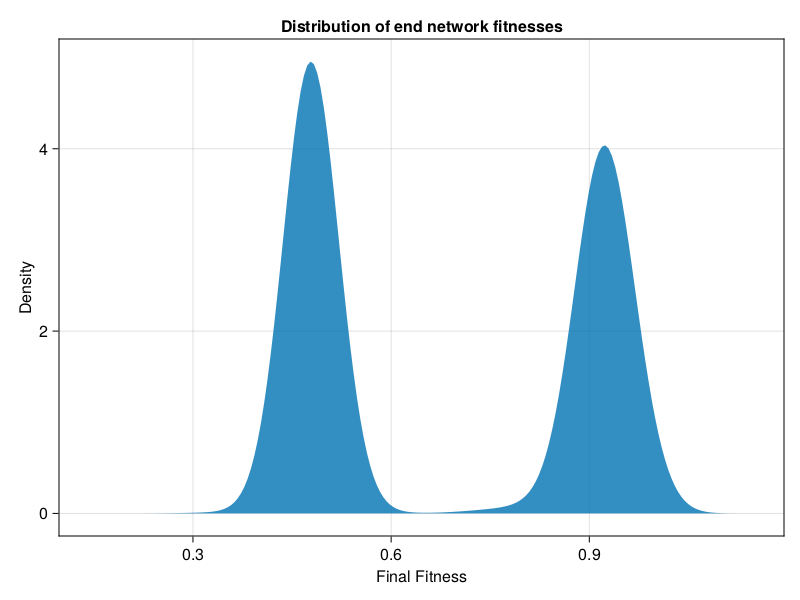

In [262]:
fig = CairoMakie.Figure()
ax = Axis(fig[1,1],xlabel = "Final Fitness",ylabel = "Density", title = "Distribution of end network fitnesses")
CairoMakie.density!(ax,end_fitness)
fig

In [263]:
all_networks = reduce(hcat,map(x->unique(x,dims = 2), gt.geno_traj))

unique_top = unique(sign.(all_networks),dims = 2)

unique_top_map = Dict((i,n) for (n,i) in enumerate(eachcol(unique_top)));

id_to_top_map = Dict((n,i) for (n,i) in enumerate(eachcol(unique_top)));

In [264]:
# cost_matrix = pairwise(hamming,unique_top)

# optimal_topology_order = get_optimal_tour(cost_matrix,GLPK.Optimizer)

# topology_reorder = Dict(i=>n for (n,i) in enumerate(optimal_topology_order[1]))

In [265]:
n_connections_top = [sum(abs.(top)) for top in eachcol(unique_top)]

topology_reorder_complexity = Dict((t,n) for (n,t) in enumerate(sortperm(n_connections_top)));

In [266]:
n_topologies = size(unique_top,2)

429

In [267]:
top_routes = map(traj->mapslices(t->unique_top_map[t],sign.(traj),dims = 1),gt.geno_traj);

In [391]:
all_unique_fitness = unique(reduce(vcat,map(x->unique(x),gt.fitness_traj)))

hist_edges = zeros(11)

hist_edges[1] = gt.initial_fitness

hist_edges[2:10] .= LinRange(gt.initial_fitness+eps(),0.9,9) |> collect

hist_edges[11] = 1.

n_fit_bin = length(hist_edges) - 1

h_fitness = fit(Histogram, all_unique_fitness, hist_edges; closed = :left) 

fitness_routes = map(traj->map(f->StatsBase.binindex(h_fitness, f),traj),gt.fitness_traj);

In [394]:
ft_route = [vcat(reshape(f,(1,length(f))),r) for (f,r) in zip(fitness_routes,top_routes)];

ft_route_tuple = [Tuple.(eachcol(x)) for x in ft_route];

ft_route_rle = map(x->rle(x)[1],ft_route_tuple);

In [395]:
ft_route_rle[1]

5-element Vector{Tuple{Int64, Int64}}:
 (1, 1)
 (5, 2)
 (6, 2)
 (9, 2)
 (10, 2)

In [396]:
unique_vertices = sort(unique(reduce(vcat,ft_route_rle)));

ft_to_vertex = Dict(i=>n for (n,i) in enumerate(unique_vertices));

vertex_to_ft = Dict(n=>i for (n,i) in enumerate(unique_vertices));

In [397]:
const n_vertices = length(unique_vertices)

1212

In [398]:
start_topology = unique_top_map[sign.(gt.initial_genotype)]

start_vertex = ft_to_vertex[(1,start_topology)]

1

In [399]:
function create_adjacency_matrix(edges)

    adj = zeros(Int64,n_vertices,n_vertices)

    for e in edges
        adj[e...] = 1
    end

    return adj
end

function EvoShell(g,nlist,vertex_to_ft,n_topologies)
    adj_matrix = adjacency_matrix(g)

    (N,j) = size(adj_matrix)

    T = Point{2,Float64}
    locs = Vector{T}(undef, N)

    θ = range(0; stop=2pi, length=n_topologies + 1)[1:(end - 1)]

    radius = 0.0
    if length(nlist[1]) > 1
        radius = 1.0
    end

    for nodes in nlist
        x = T[(radius * cos(θ[vertex_to_ft[n][2]]), radius * sin(θ[vertex_to_ft[n][2]])) for n in nodes]
        locs[nodes] = x
        radius += 1.0
    end
    return locs
end

function EvoShell(g,nlist,vertex_to_ft,topology_reorder,n_topologies)
    adj_matrix = adjacency_matrix(g)

    (N,j) = size(adj_matrix)

    T = Point{2,Float64}
    locs = Vector{T}(undef, N)

    θ = range(0; stop=2pi, length=n_topologies + 1)[1:(end - 1)]

    radius = 0.0
    if length(nlist[1]) > 1
        radius = 1.0
    end

    for nodes in nlist
        x = T[(radius * cos(θ[topology_reorder[vertex_to_ft[n][2]]]), radius * sin(θ[topology_reorder[vertex_to_ft[n][2]]])) for n in nodes]
        locs[nodes] = x
        radius += 1.0
    end
    return locs
end

function outer_ring!(ax,n_connections_top,topology_reorder,n_topologies,color_palette)

    max_radius = 11.

    reverse_map = Dict(angle_n=>top for (top,angle_n) in topology_reorder_complexity)

    T = Point{2,Float64}
    
    θ = range(0; stop=2pi, length=n_topologies + 1)[1:(end - 1)]

    color_id = [let top = reverse_map[n]; (θ,Int(n_connections_top[top])) end for (n,θ) in enumerate(θ)]

    end_theta = []
    end_theta_colors = []   

    for i in 1:length(color_id)-1
        if color_id[i+1][2] > color_id[i][2]
            push!(end_theta,color_id[i][1])
            push!(end_theta_colors,color_id[i][2])
        end
    end

    push!(end_theta,color_id[end][1])
    push!(end_theta_colors,color_id[end][2])

    x = T[(max_radius * cos(θ), max_radius * sin(θ)) for (n,θ) in enumerate(θ)]

    end_x = T[(max_radius * cos(θ), max_radius * sin(θ)) for θ in end_theta]

    # text_x = [max_radius * cos(θ) for θ in end_theta]

    # text_y = [max_radius * sin(θ) for θ in end_theta]

    CairoMakie.lines!(ax,x,color = color_palette[map(x->x[2],color_id)],linewidth = 5.)
    CairoMakie.scatter!(ax,end_x,color = color_palette[end_theta_colors],markersize = 20.)

    offset_θ = [(75 * cos(θ), 75 * sin(θ)) for θ in end_theta]

    # for i in 1:length(end_theta)
    #     CairoMakie.text!(ax,end_x[i],text = string(end_theta_colors[i]) * " connections", align = (:center, :center),offset = offset_θ[i],color = color_palette[end_theta_colors[i]])
    # end

    CairoMakie.text!(ax,end_x,text = string.(end_theta_colors) .* " connections", align = (:center, :center),offset = offset_θ,color = color_palette[end_theta_colors])

    CairoMakie.xlims!(ax,-13,13)
    CairoMakie.ylims!(ax,-13,13)
    
end

outer_ring! (generic function with 1 method)

In [400]:
ft_vertex_route = map(traj->map(ft->ft_to_vertex[ft],traj),ft_route_rle);

ft_edge_route = map(x->[(x[i],x[i+1]) for i in 1:length(x)-1],ft_vertex_route);

ft_adj_route = map(er->create_adjacency_matrix(er),ft_edge_route);

ft_graph_route = map(ar -> SimpleDiGraph(ar),ft_adj_route);

cyclic_routes = is_cyclic.(ft_graph_route);

In [401]:
ft_edge_route_graph = map(x->[Edge((x[i],x[i+1])) for i in 1:length(x)-1],ft_vertex_route);

In [410]:
vertex_to_ft[2]

(2, 1)

In [411]:
# order(gex) = vcat([[1]],[let vertex_at_fitness = findall(v->vertex_to_ft[v][1] == n,vertices(gex)) ; deleteat!(vertex_at_fitness ,vertex_at_fitness .== start_vertex) end for n in 1:n_fit_bin])

order(gex) = [findall(v->vertex_to_ft[v][1] == n,vertices(gex)) for n in 1:n_fit_bin]

order (generic function with 1 method)

In [412]:
gex_all = reduce(union,ft_graph_route);

In [414]:
# fig = CairoMakie.Figure(resolution = (2000,2000))

# ax = Axis(fig[1,1])

# layout = Shell(nlist = order(gex_all))

# graphplot!(ax,gex_all, layout=layout,edge_plottype =:beziersegments)

# fig

In [415]:
function create_transition_matrix(edges)

    adj = zeros(Int64,n_vertices,n_vertices)

    vert = 1:n_vertices

    start_counts = zeros(Int64,n_vertices)
    end_counts = zeros(Int64,n_vertices)

    for e in edges
        adj[e...] += 1
        start_counts[e[1]] += 1
        end_counts[e[2]] += 1
    end

    absorbing_states = (end_counts .!= 0) .&& (start_counts .== 0) 

    t_mat = adj ./ [x == 0 ? 1. : x for x in start_counts]

    p_visit = end_counts ./ sum(end_counts)

    for s in vert[absorbing_states]
        t_mat[s,s] = 1.
    end

    return t_mat,p_visit,absorbing_states 
end

tmat,p_visit,absorbing_states = create_transition_matrix(reduce(vcat,ft_edge_route));

sum( 1 .- sum(tmat,dims = 2))

6.661338147750939e-15

In [418]:
# converged = map(x->x[end][1] > 6,ft_route_rle); # beware, histogram edges changes each time

# converged = map(x->x[end][1] > 6,ft_route_rle); # beware, histogram edges changes each time

converged = map(x->x[end] > 0.9,gt.fitness_traj);

In [419]:
vertex_nc = unique(reduce(vcat,ft_vertex_route[.!converged]))
vertex_c = unique(reduce(vcat,ft_vertex_route[converged]));

In [430]:
# P(visit and converge) = P(converge | visit)*P(visit)

prob_visit_vertex(vertex) = sum([vertex ∈ traj for traj in ft_vertex_route])/length(ft_vertex_route)

# prob_visit_vertex(vertex) = vertex == 1 ? 1. : p_visit[vertex]

# prob_converged_given_vertex(vertex) = (sum([vertex ∈ traj for traj in ft_vertex_route[converged]]) / sum([vertex ∈ traj for traj in ft_vertex_route]))

prob_converged_given_vertex(vertex) = (sum([vertex ∈ traj for traj in ft_vertex_route[converged]]) / sum(converged))*(sum(converged)/length(ft_vertex_route))/prob_visit_vertex(vertex)

# prob_traverse_edge(edge) = sum([edge ∈ traj for traj in ft_edge_route_graph])/length(ft_edge_route_graph)

# prob_converged_given_edge(edge) = sum([edge ∈ traj for traj in ft_edge_route_graph[converged]]) / sum([edge∈ traj for traj in ft_edge_route_graph])

prob_edge_and_vertex(edge) = tmat[src(edge),dst(edge)]*prob_visit_vertex(src(edge))

prob_edge_and_vertex (generic function with 1 method)

In [433]:
vertex_prob_exclude_start = [prob_visit_vertex(vertex)  for vertex in 2:length(unique_vertices)];

vertex_prob_converge_exclude_start = [prob_converged_given_vertex(vertex) for vertex in 2:length(unique_vertices)];

# edge_prob_converge_exclude_start = [prob_converged_given_edge(edge) for edge in edges(gex_all)];

edge_prob_exclude_start = [prob_edge_and_vertex(edge) for edge in edges(gex_all)];

In [434]:
sum(vertex_prob_exclude_start)

4.407599999999999

In [435]:
1/quantile(vertex_prob_exclude_start,0.8)

500.0

In [436]:
1/quantile(edge_prob_exclude_start,0.8)

625.0

In [437]:
converge_prob_color = cgrad([:red, :orange, :green], [0.0, 0.5, 1.])

color_vertex(vertex,scalar) = (converge_prob_color[prob_converged_given_vertex(vertex)],scalar*prob_visit_vertex(vertex))

# color_edge_convergence(edge,scalar) = (converge_prob_color[prob_converged_given_edge(edge)],scalar*prob_edge_and_vertex(edge))

color_edge_traversal(edge,scalar) = (:black,scalar*prob_edge_and_vertex(edge))

color_edge_traversal (generic function with 1 method)

In [456]:
choices = [1855,1284]

2-element Vector{Int64}:
 1855
 1284

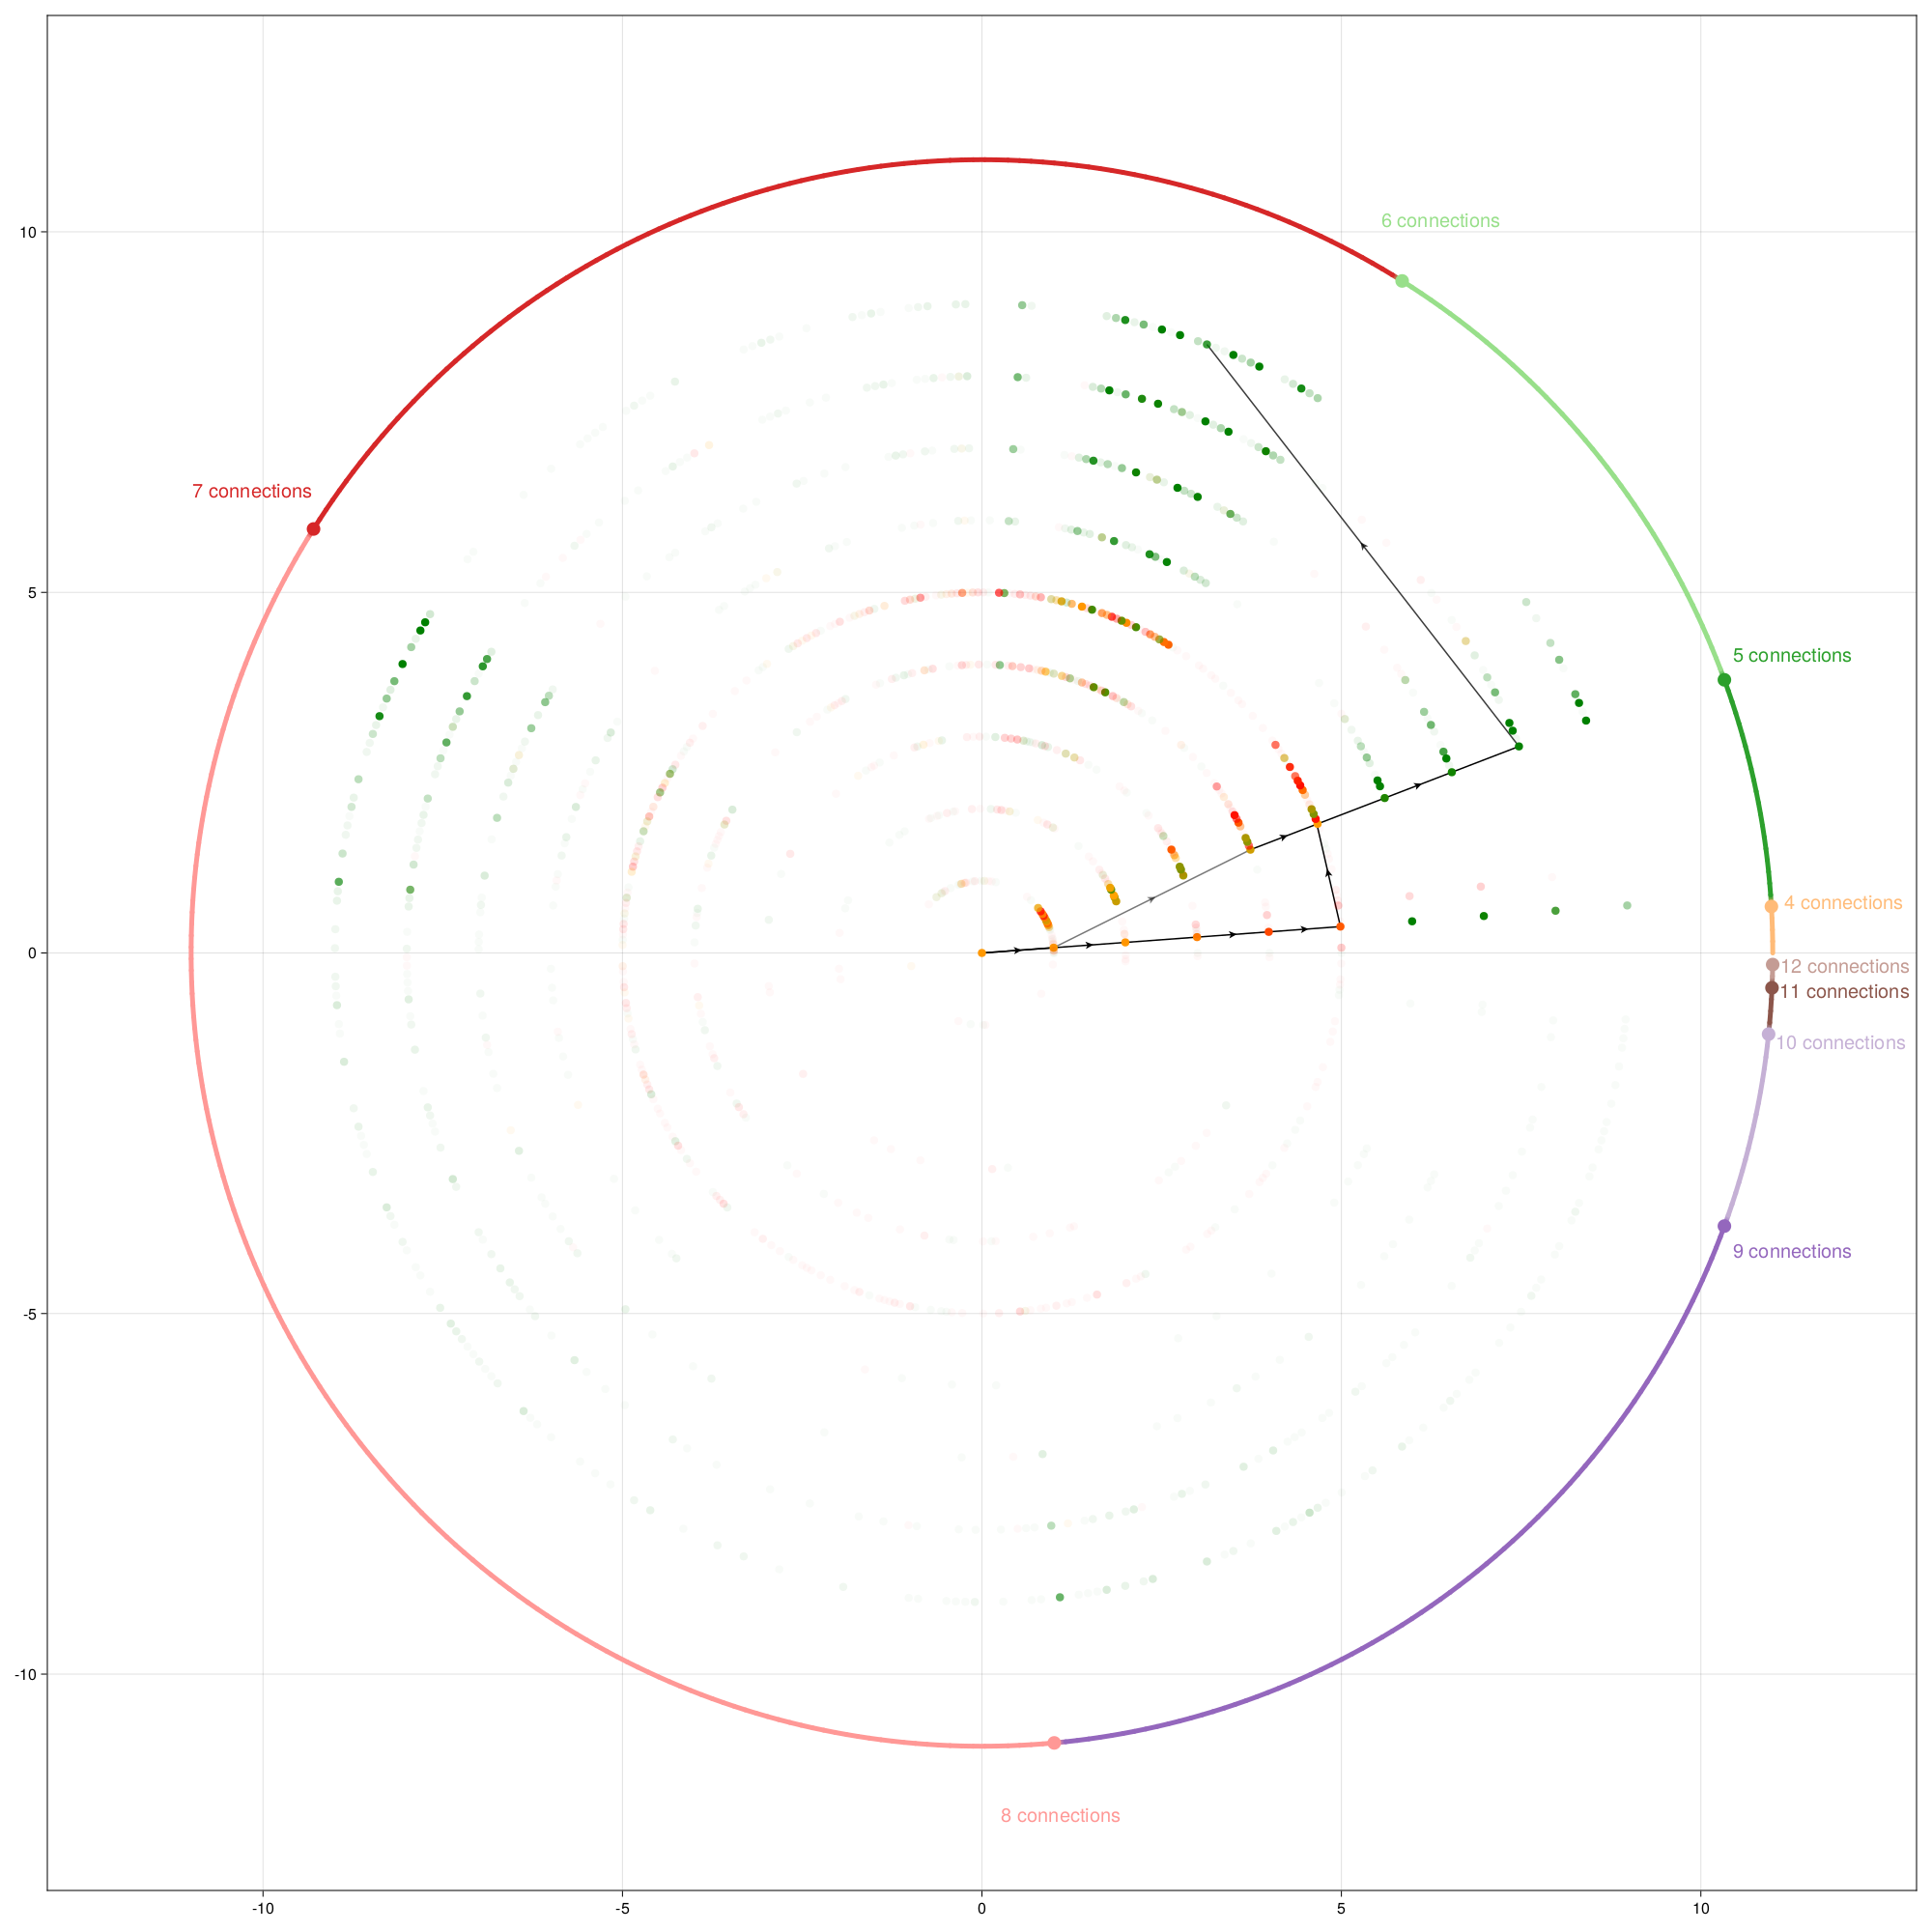

In [458]:
# choices = sample(1:length(ft_graph_route),2,replace = false)

choices = [1855,1284]

gex_subset = reduce(union,ft_graph_route[choices]);

# rem_vertex!(gex_subset,1)

fig = CairoMakie.Figure(resolution = (2000,2000))

ax = Axis(fig[1,1])

layout = Shell(nlist = order(gex_subset))

v_color = [color_vertex(v,1/quantile(vertex_prob_exclude_start,0.95)) for v in vertices(gex_subset)]

e_color = [color_edge_traversal(e,1/quantile(edge_prob_exclude_start,0.95)) for e in edges(gex_subset)]

graphplot!(ax,gex_subset, layout=x->EvoShell(x,order(gex_all),vertex_to_ft,topology_reorder_complexity,n_topologies),edge_plottype =:beziersegments, node_color = v_color, edge_color = e_color)

outer_ring!(ax,n_connections_top,topology_reorder_complexity,n_topologies,palette(:tab20))


fig

In [459]:
# # function diffusion_exemplar()
# function randomwalk_weighted(g::AG, s::Integer, prob_mat::Matrix,niter::Integer; seed::Int=-1) where AG <: AbstractGraph{T} where T
#     s in vertices(g) || throw(BoundsError())
#     rng = getRNG(seed)
#     visited = Vector{T}()
#     sizehint!(visited, niter)
#     currs = s
#     i = 1
#     while i <= niter
#         push!(visited, currs)
#         i += 1
#         nbrs = outneighbors(g, currs)
#         length(nbrs) == 0 && break

#         outn = outneighbors(g, currs)

#         poss_states =  cat(currs,outn,dims = 1)

#         prob = cat(1. - sum(prob_mat[currs,outn]),prob_mat[currs,outn],dims = 1)

#         currs = sample(poss_states, Weights(prob))
#     end
#     return visited[1:(i - 1)]
# end


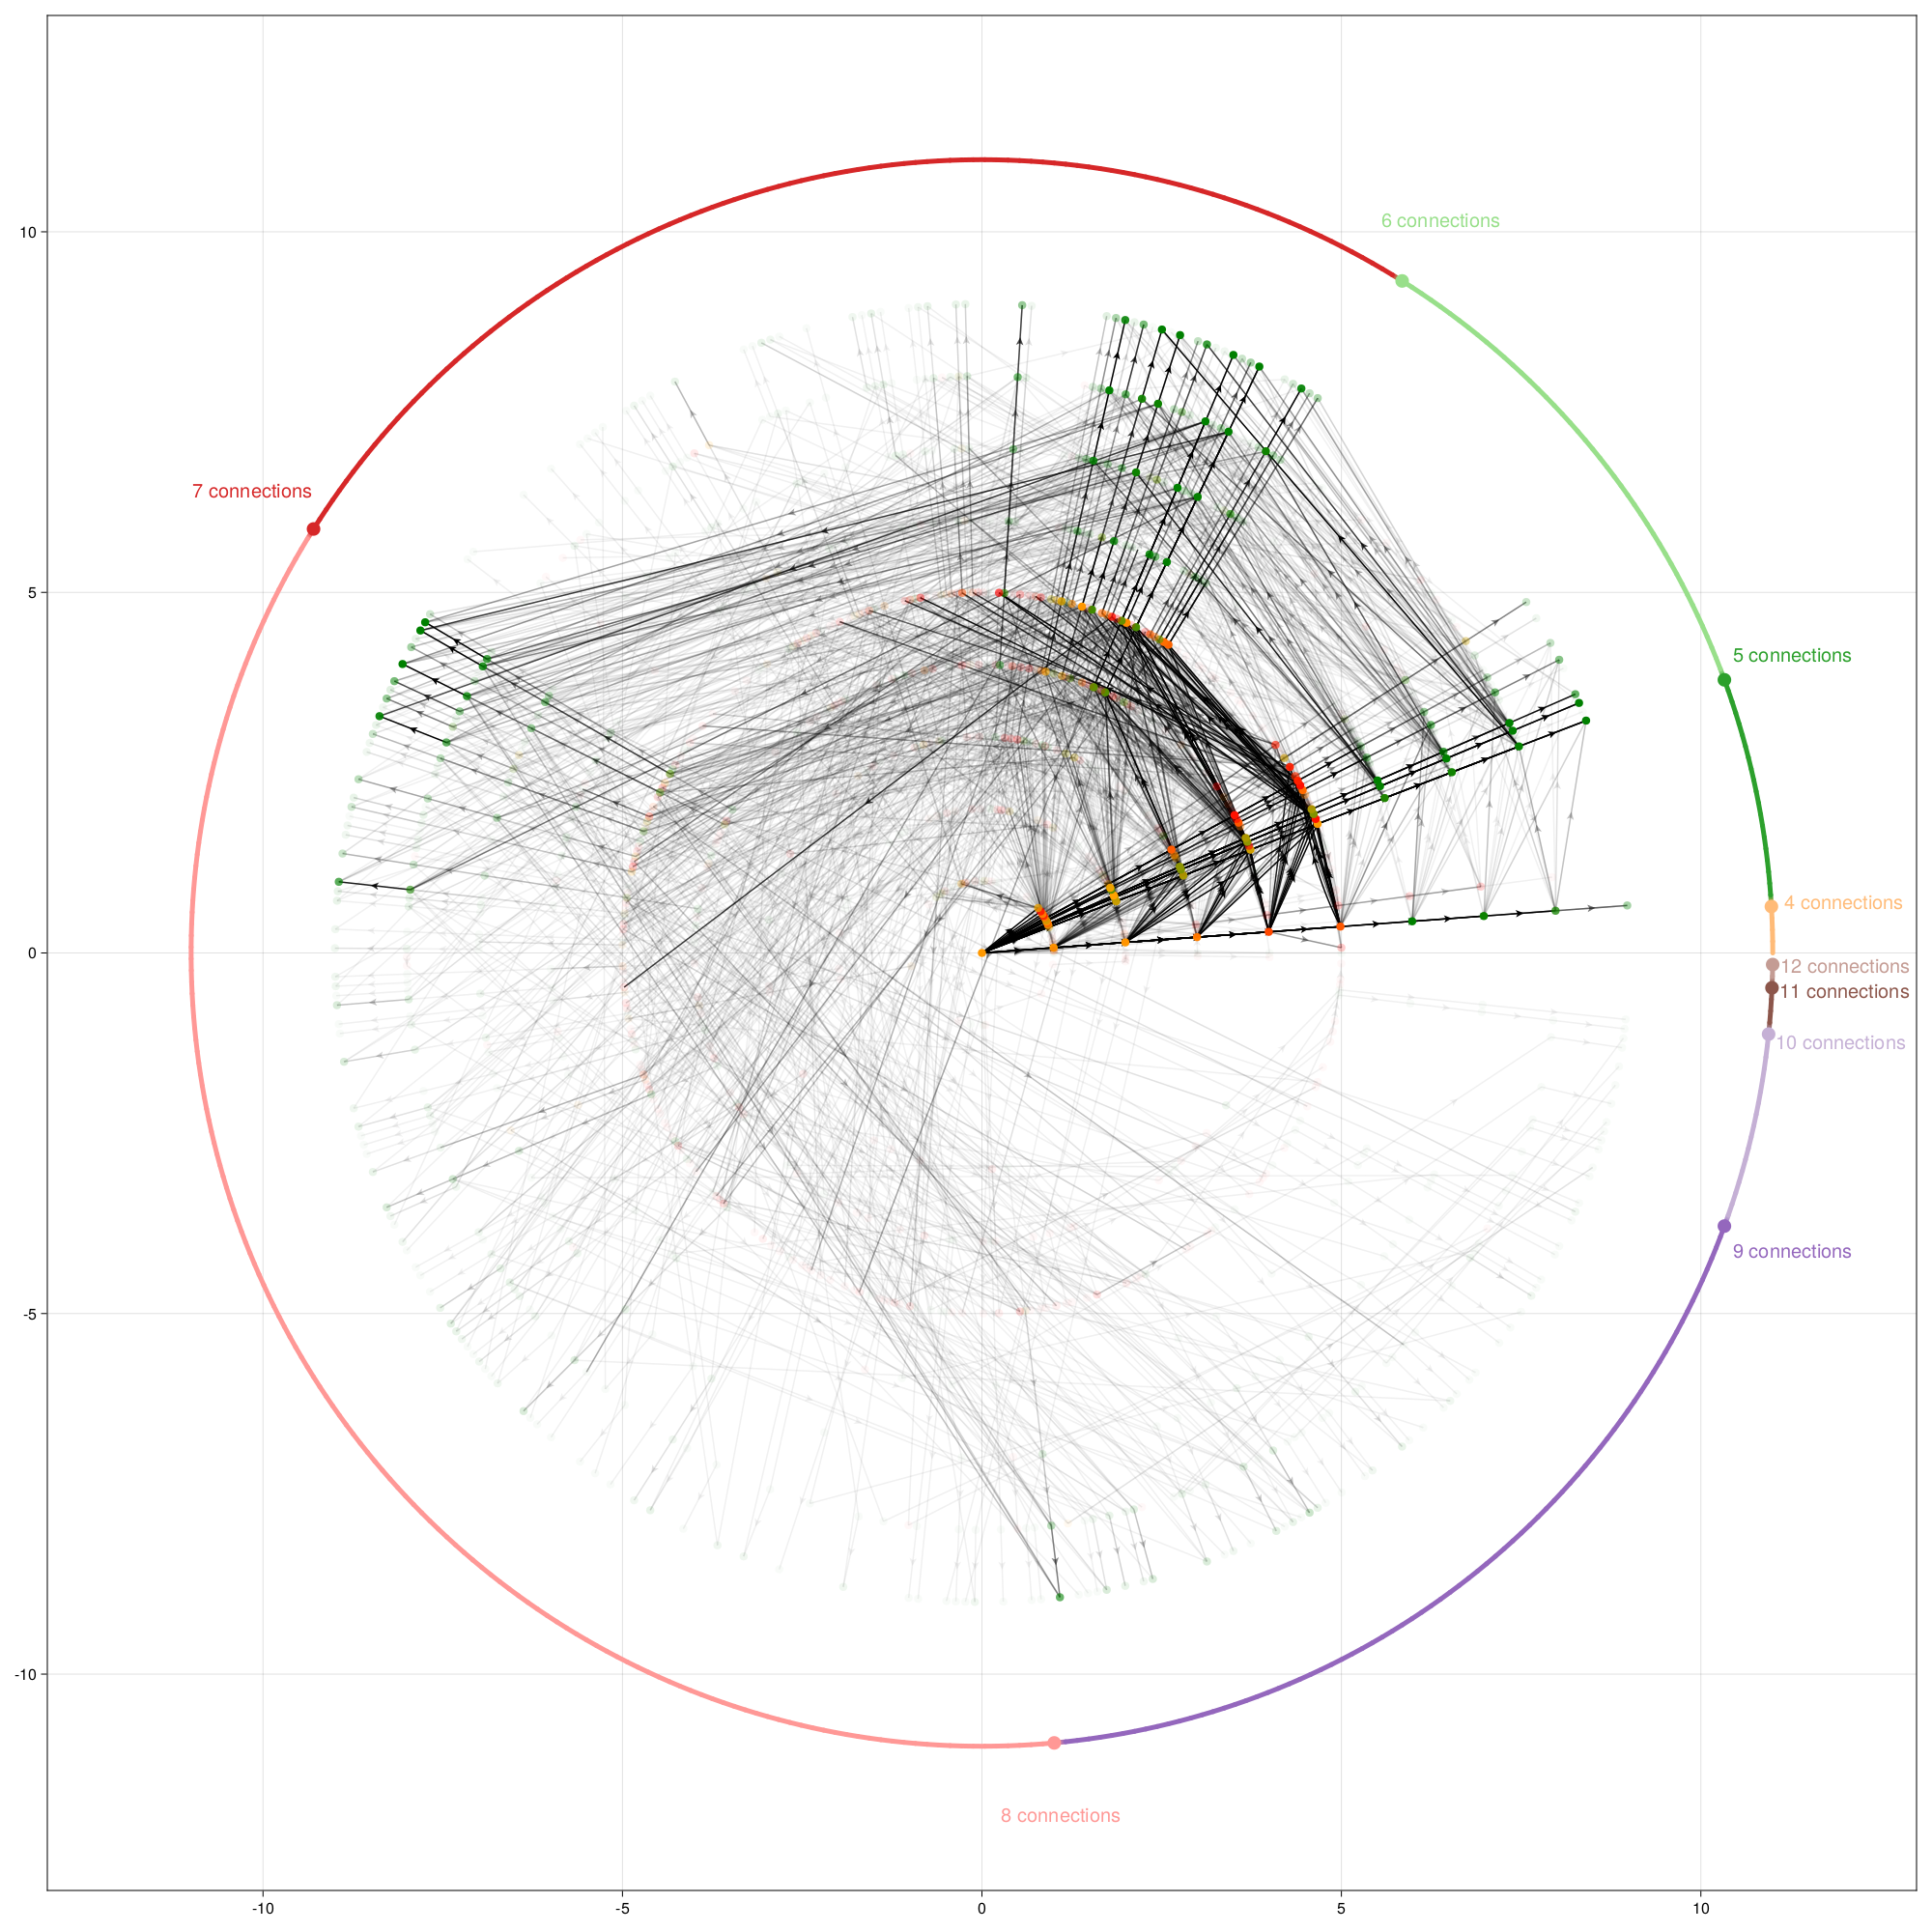

In [460]:
fig = CairoMakie.Figure(resolution = (2000,2000))

ax = Axis(fig[1,1])

layout = Shell(nlist = order(gex_all))

v_color = [color_vertex(v,1/quantile(vertex_prob_exclude_start,0.95)) for v in vertices(gex_all)]

# e_color = [color_edge_convergence(e,1/quantile(edge_prob_exclude_start,0.9)) for e in edges(gex_all)]

e_color = [color_edge_traversal(e,1/quantile(edge_prob_exclude_start,0.95)) for e in edges(gex_all)]

graphplot!(ax,gex_all, layout=x->EvoShell(x,order(gex_all),vertex_to_ft,topology_reorder_complexity,n_topologies),edge_plottype =:beziersegments, node_color = v_color, edge_color = e_color)

outer_ring!(ax,n_connections_top,topology_reorder_complexity,n_topologies,palette(:tab20))

fig

In [313]:
# gex_tr = transitivereduction(gex_all)

# # is_strongly_connected(gex_all)

# # is_weakly_connected(gex_all)

# fig = CairoMakie.Figure(resolution = (2000,2000))

# ax = Axis(fig[1,1])

# layout = Shell(nlist = order(gex_tr ))

# v_color = [color_vertex(v,1/quantile(vertex_prob_exclude_start,0.8)) for v in vertices(gex_tr )]

# e_color = [color_edge(e,1/quantile(edge_prob_exclude_start,0.9)) for e in edges(gex_tr )]

# graphplot!(ax,gex_tr , layout=x->EvoShell(x,order(gex_tr),vertex_to_ft,topology_reorder,n_topologies),edge_plottype =:beziersegments, node_color = v_color)

# fig

In [314]:
end_vertices = map(x->x[end],ft_vertex_route)

end_vertex_count = countmap(end_vertices)

end_vertex_count_converged = [converged[i] ? haskey(end_vertex_count,i) ? end_vertex_count[i] : 0 : 0 for i in 1:n_vertices]

end_vertex_count_non_converged = [!converged[i] ? haskey(end_vertex_count,i) ? end_vertex_count[i] : 0 : 0 for i in 1:n_vertices];

In [315]:
most_visited_converged_id = sortperm(end_vertex_count_converged,rev = true)
most_visited_non_converged_id = sortperm(end_vertex_count_non_converged,rev = true);

most_visited_converged = map(x->end_vertex_count_converged[x],most_visited_converged_id)
most_visited_non_converged = map(x->end_vertex_count_non_converged[x],most_visited_non_converged_id );

In [316]:
filter(x->x[end][2] == most_visited_converged_id[1],ft_edge_route)

197-element Vector{Vector{Tuple{Int64, Int64}}}:
 [(1, 282)]
 [(1, 180), (180, 282)]
 [(1, 34), (34, 282)]
 [(1, 180), (180, 282)]
 [(1, 180), (180, 282)]
 [(1, 115), (115, 282)]
 [(1, 282)]
 [(1, 34), (34, 115), (115, 282)]
 [(1, 282)]
 [(1, 115), (115, 282)]
 ⋮
 [(1, 115), (115, 282)]
 [(1, 282)]
 [(1, 180), (180, 282)]
 [(1, 115), (115, 180), (180, 282)]
 [(1, 34), (34, 180), (180, 282)]
 [(1, 14), (14, 180), (180, 282)]
 [(1, 282)]
 [(1, 282)]
 [(1, 282)]

In [317]:
filter(x->x[end][2] == most_visited_non_converged_id[1],ft_edge_route)

95-element Vector{Vector{Tuple{Int64, Int64}}}:
 [(1, 181), (181, 283), (283, 876), (876, 1066)]
 [(1, 116), (116, 283), (283, 876), (876, 1066)]
 [(1, 68), (68, 181), (181, 283), (283, 745), (745, 876), (876, 1066)]
 [(1, 115), (115, 282), (282, 283), (283, 745), (745, 876), (876, 1066)]
 [(1, 34), (34, 181), (181, 283), (283, 643), (643, 745), (745, 876), (876, 1066)]
 [(1, 181), (181, 283), (283, 558), (558, 745), (745, 1066)]
 [(1, 283), (283, 643), (643, 876), (876, 1066)]
 [(1, 181), (181, 283), (283, 745), (745, 1066)]
 [(1, 68), (68, 283), (283, 558), (558, 1066)]
 [(1, 115), (115, 282), (282, 557), (557, 642), (642, 1066)]
 ⋮
 [(1, 116), (116, 181), (181, 283), (283, 643), (643, 745), (745, 876), (876, 1066)]
 [(1, 34), (34, 283), (283, 876), (876, 1066)]
 [(1, 34), (34, 282), (282, 557), (557, 744), (744, 875), (875, 1066)]
 [(1, 68), (68, 116), (116, 283), (283, 643), (643, 745), (745, 1066)]
 [(1, 282), (282, 557), (557, 744), (744, 876), (876, 1066)]
 [(1, 34), (34, 180), 

In [318]:
function get_k_shortest_paths(g,src,dest, dist_mat::Matrix,k)

    all_routes = []

    edge_dictionary = Dict()

    for (n,d) in enumerate(dest)
        k_short = yen_k_shortest_paths(g,src,d, dist_mat,k)
        all_k_path_edges = []
        for k_path in k_short.paths
            for i in 1:length(k_path)-1
                # push!(all_k_path_edges,Edge((k_path[i],k_path[i+1])))
                e = Edge((k_path[i],k_path[i+1]))
                if haskey(edge_dictionary,e)
                    if !(n ∈ edge_dictionary[e])
                        push!(edge_dictionary[e],n)
                    end
                else
                    edge_dictionary[e] = [n]
                end     
            end
            push!(all_routes,k_path)
        end
        # edge_dictionary[d] = refresh_type(unique(all_k_path_edges))
    end

    kshort_edge_route = map(x->[(x[i],x[i+1]) for i in 1:length(x)-1],all_routes);

    kshort_adj_route = map(er->create_adjacency_matrix(er),kshort_edge_route);

    kshort_graph_route = map(ar -> SimpleDiGraph(ar),kshort_adj_route);

    return kshort_graph_route,edge_dictionary
end

function get_k_shortest_paths(g,src,dest,ft_edge_route,k)

    all_routes = []

    edge_dictionary = Dict()

    for (n,d) in enumerate(dest)
        dist_mat,p_visit,absorbing_states  = create_transition_matrix(reduce(vcat,filter(x->x[end][2] == d,ft_edge_route)));
        k_short = yen_k_shortest_paths(g,src,d, dist_mat,k)
        all_k_path_edges = []
        for k_path in k_short.paths
            for i in 1:length(k_path)-1
                # push!(all_k_path_edges,Edge((k_path[i],k_path[i+1])))
                e = Edge((k_path[i],k_path[i+1]))
                if haskey(edge_dictionary,e)
                    if !(n ∈ edge_dictionary[e])
                        push!(edge_dictionary[e],n)
                    end
                else
                    edge_dictionary[e] = [n]
                end     
            end
            push!(all_routes,k_path)
        end
        # edge_dictionary[d] = refresh_type(unique(all_k_path_edges))
    end

    kshort_edge_route = map(x->[(x[i],x[i+1]) for i in 1:length(x)-1],all_routes);

    kshort_adj_route = map(er->create_adjacency_matrix(er),kshort_edge_route);

    kshort_graph_route = map(ar -> SimpleDiGraph(ar),kshort_adj_route);

    return kshort_graph_route,edge_dictionary
end

get_k_shortest_paths (generic function with 2 methods)

In [326]:
# target_1 = most_visited_converged[2]
# target_2 = most_visited_converged[1]

# targets = [most_visited_converged[1],most_visited_converged[2],most_visited_converged[3],most_visited_non_converged[1],most_visited_non_converged[2],most_visited_non_converged[3]]

# targets = [most_visited_non_converged_id[1],most_visited_converged_id[1]]

targets = [most_visited_converged_id[1]]

# kshort_graph_route,edge_dictionary = get_k_shortest_paths(gex_all,1,targets, -1 .* log.(tmat),1);

kshort_graph_route,edge_dictionary = get_k_shortest_paths(gex_all,1,targets,ft_edge_route,20);


In [327]:
# color_edge_conditional(edge,scalar) = (converge_prob_color[prob_converged_given_edge(edge)],scalar*prob_traverse_edge(edge))

color_edge_class(edge,edge_classification,color_palette) = length(edge_dictionary[edge]) > 1 ? :purple : color_palette[edge_dictionary[edge][1]]

color_edge_class (generic function with 1 method)

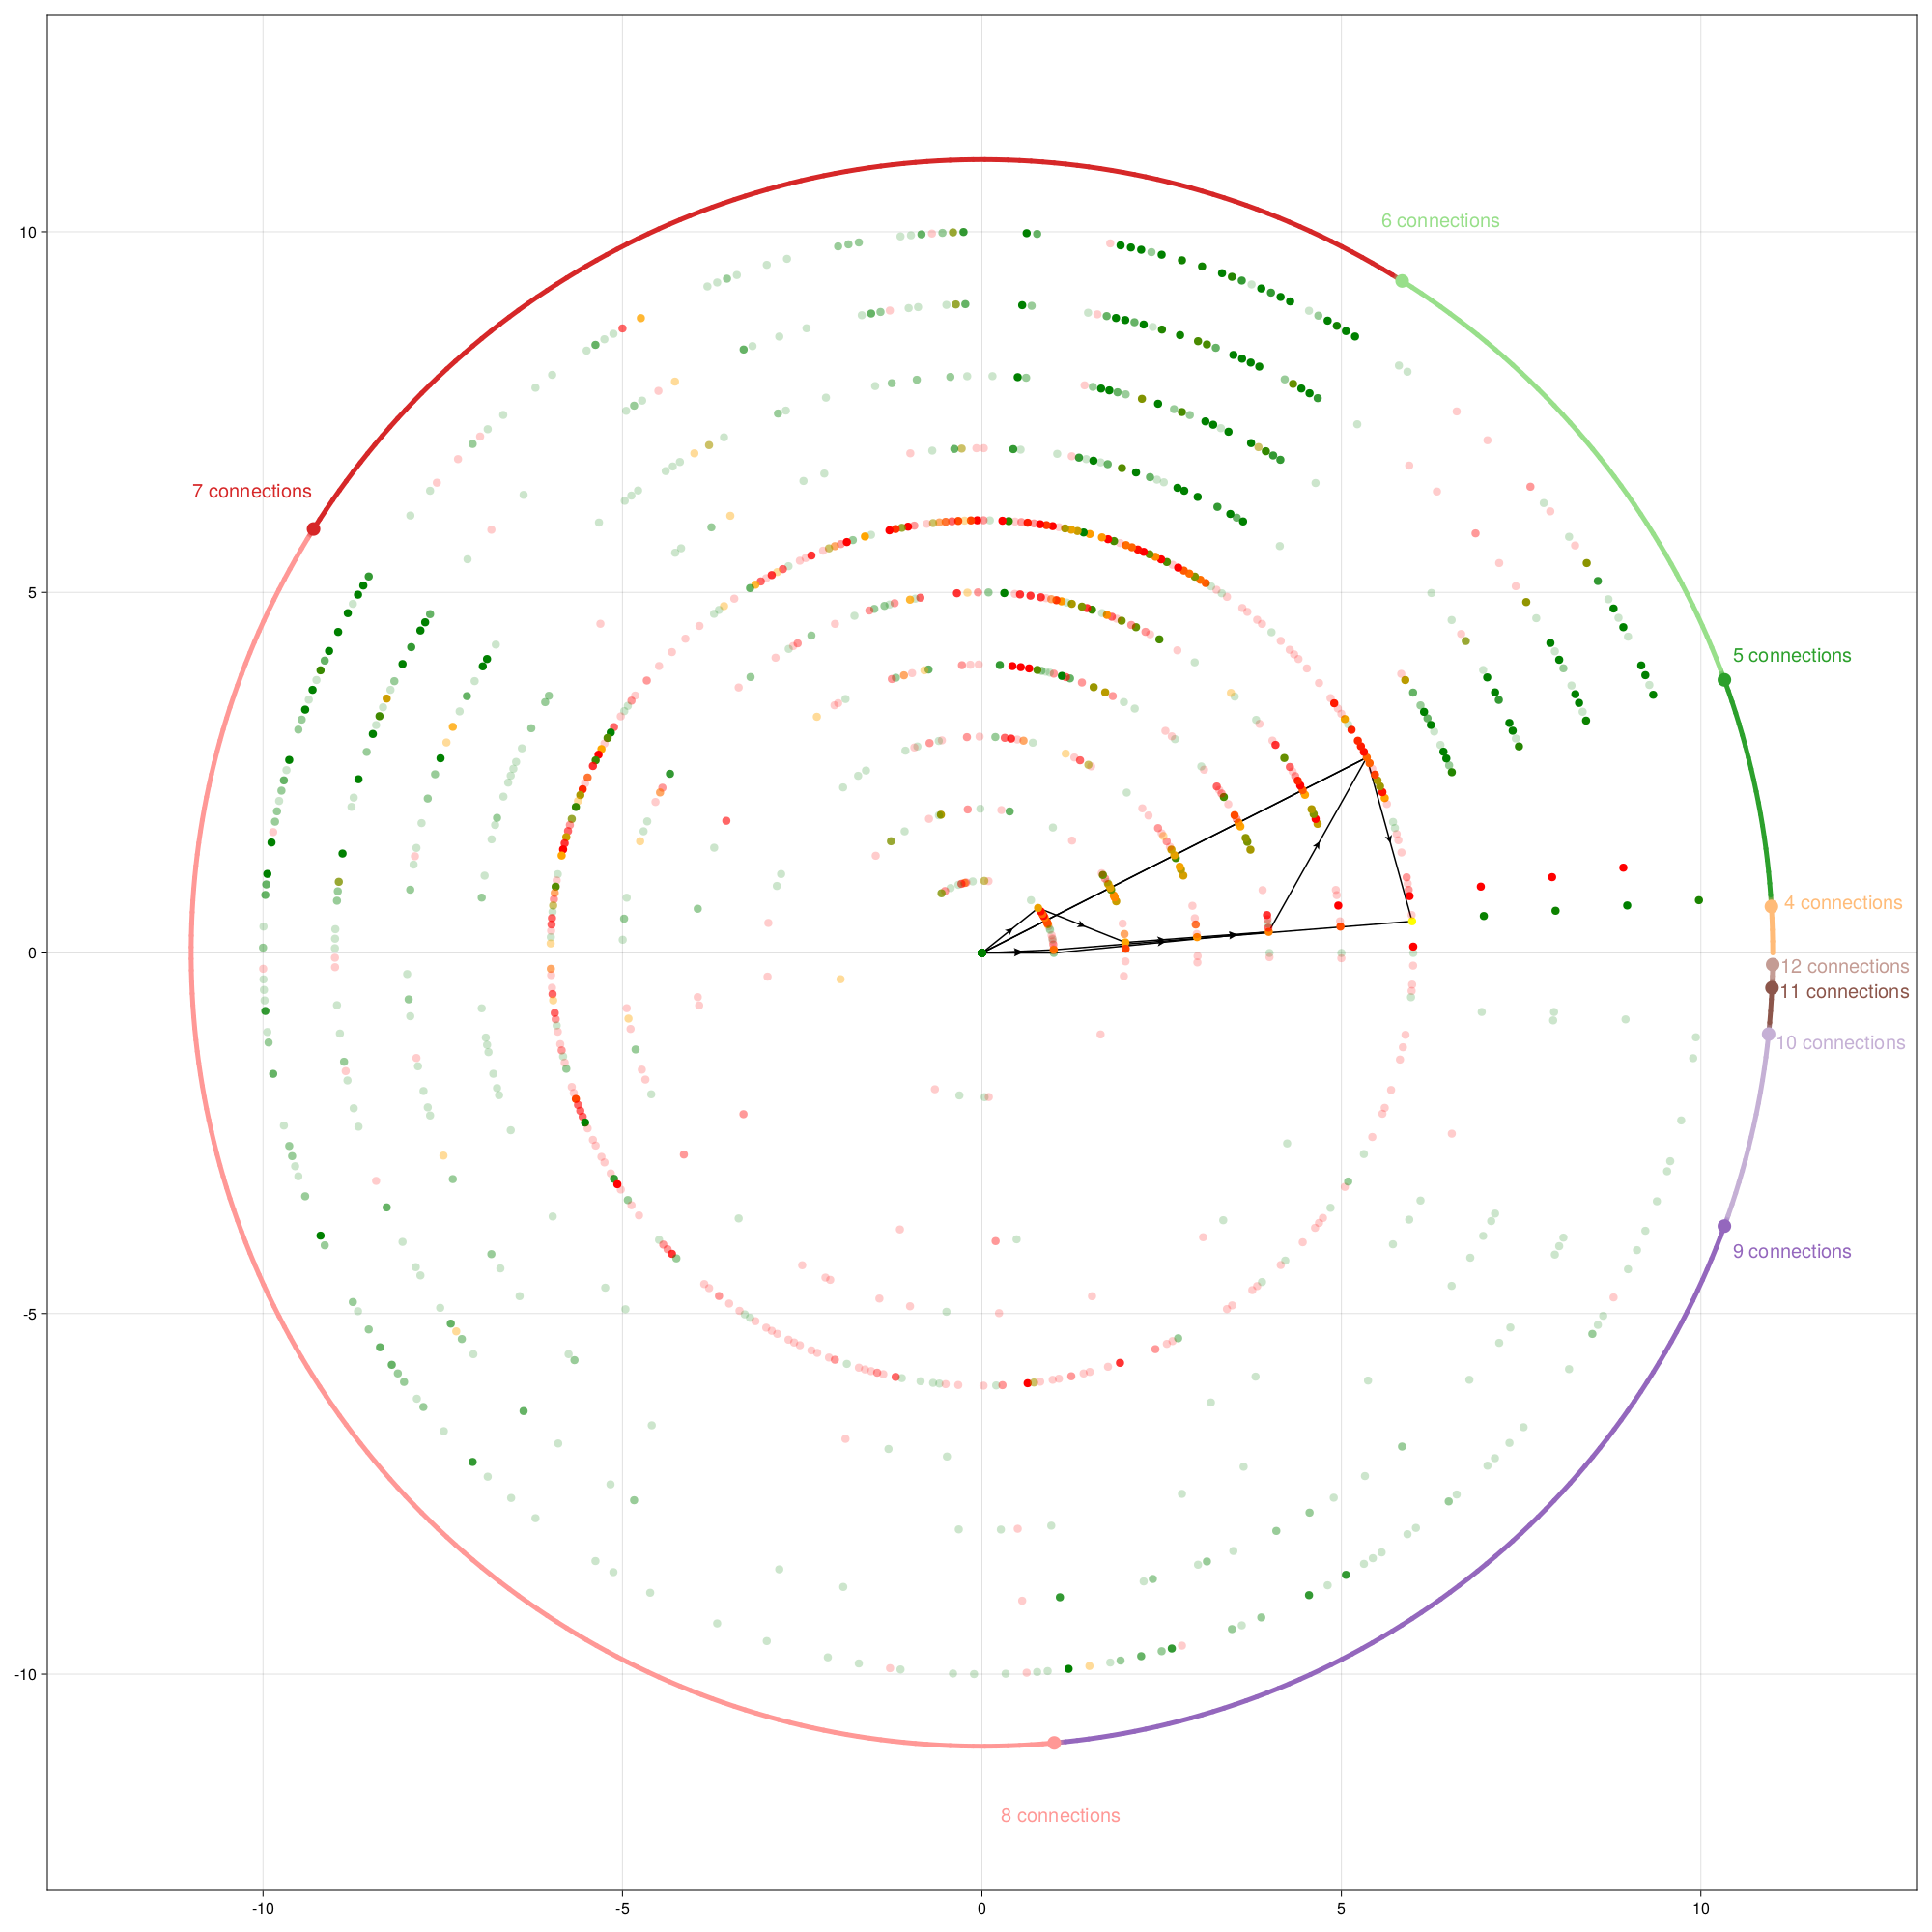

In [328]:
gex_subset = transitivereduction(reduce(union,kshort_graph_route))

# rem_vertex!(gex_subset,1)

fig = CairoMakie.Figure(resolution = (2000,2000))

ax = Axis(fig[1,1])

layout = Shell(nlist = order(gex_subset))

v_color = [v ∈ targets ? :yellow : color_vertex(v,1/quantile(vertex_prob_exclude_start,0.8)) for v in vertices(gex_subset)]

# e_color = [color_edge(e,1/quantile(edge_prob_exclude_start,0.9)) for e in edges(gex_subset)]

# e_color = [color_edge_class(e,edge_dictionary,[:green,:red]) for e in edges(gex_subset)]

e_color = [:black for e in edges(gex_subset)]

# e_color = [color_edge_traversal(e,1/quantile(edge_prob_exclude_start,0.95)) for e in edges(gex_subset)]

graphplot!(ax,gex_subset, layout=x->EvoShell(x,order(gex_subset),vertex_to_ft,topology_reorder_complexity,n_topologies),edge_plottype =:beziersegments, node_color = v_color, edge_color = e_color)

outer_ring!(ax,n_connections_top,topology_reorder_complexity,n_topologies,palette(:tab20))

fig

In [ ]:
vertex_p_converged_and_visited = [prob_converged_given_vertex(vertex)*prob_visit_vertex(vertex) for vertex in 2:length(unique_vertices)];
vertex_p_not_converged_and_visited = [(1-prob_converged_given_vertex(vertex))*prob_visit_vertex(vertex) for vertex in 2:length(unique_vertices)];

In [ ]:
argmax(vertex_p_converged_and_visited)

In [ ]:
argmax(vertex_p_not_converged_and_visited)

In [ ]:
vertex_to_ft[122]

In [ ]:
vertex_to_ft[140]

In [ ]:
argmax(vertex_p_not_converged_and_visited)

In [ ]:
vertex_p_not_converged_and_visited[140]

In [ ]:
absorbing_states[140]